In [1]:
import sys
sys.path.append("..")   # this allows us to import from sibling directory

import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix
from code_to_import.dataset_preprocessing import ProductionModeDataset

import torch
# from sklearn.inspection import permutation_importance
import numpy as np
import uproot
import torch.nn as nn
from matplotlib import pyplot as plt

from skorch import NeuralNetClassifier

from code_to_import.Classifier_module import Classifier
from torch.autograd import Variable


In [2]:
################# THIS IS WHERE YOU CHOOSE WHAT TO LOAD ################################
path_to_model = "../models/two_layers/twoLayerModel_weights_gpu_emu0"

title = "confusion_plot_twoLayerModel_weights_gpu_emu0"

event_type = "emu"  # could be ee, emu, mumu
root_path = "/depot-new/cms/top/mcnama20/TopSpinCorr-Run2-Entanglement/CMSSW_10_2_22/src/TopAnalysis/Configuration/analysis/diLeptonic/three_files/Nominal"

file = root_path + "/" + event_type + "_modified_root_1.root"

In [3]:
# model = 0
model = Classifier()
model.load_state_dict(torch.load(path_to_model))
model.eval()

Classifier(
  (model): Sequential(
    (0): Linear(in_features=80, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=3, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
  )
)

In [4]:
data_object = ProductionModeDataset(file)
x = data_object.get_eval_data()

['lb_delta_eta', 'lbbar_delta_eta', 'lnu_delta_eta', 'lnubar_delta_eta', 'lbarb_delta_eta', 'lbarbbar_delta_eta', 'lbarnu_delta_eta', 'lbarnubar_delta_eta', 'bnu_delta_eta', 'bnubar_delta_eta', 'bbarnu_delta_eta', 'bbarnubar_delta_eta', 'lb_delta_phi', 'lbbar_delta_phi', 'lnu_delta_phi', 'lnubar_delta_phi', 'lbarb_delta_phi', 'lbarbbar_delta_phi', 'lbarnu_delta_phi', 'lbarnubar_delta_phi', 'bnu_delta_phi', 'bnubar_delta_phi', 'bbarnu_delta_phi', 'bbarnubar_delta_phi', 'wplusb_delta_eta', 'wplusbbar_delta_eta', 'wminusb_delta_eta', 'wminusbbar_delta_eta', 'wplusb_delta_phi', 'wplusbbar_delta_phi', 'wminusb_delta_phi', 'wminusbbar_delta_phi', 'top_eta', 'top_boosted_eta', 'tbar_eta', 'tbar_boosted_eta', 'ttbar_delta_eta', 'ttbar_eta', 'llbar_delta_eta', 'bbbar_delta_eta', 'nunubar_delta_eta', 'top_phi', 'tbar_phi', 'ttbar_phi', 'ttbar_delta_phi', 'llbar_phi', 'llbar_delta_phi', 'bbbar_phi', 'bbbar_delta_phi', 'nunubar_phi', 'nunubar_delta_phi', 'l_eta', 'lbar_eta', 'l_phi', 'lbar_phi', '

In [5]:
weight = x[:,81]
target = x[:,80]
target = Variable(torch.from_numpy(target).type(torch.LongTensor))
y = np.transpose(x)
y = np.delete(y, [80, 81, 82], 0)
y = np.transpose(y)
input = Variable(torch.from_numpy(y).type(torch.Tensor))

In [6]:
nn = NeuralNetClassifier(model, max_epochs=0, lr=0.00, batch_size=5000)
nn.initialize()

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Classifier(
    (model): Sequential(
      (0): Linear(in_features=80, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Linear(in_features=256, out_features=3, bias=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  ),
)

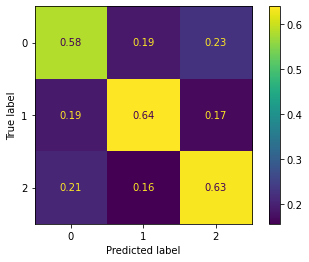

<Figure size 432x288 with 0 Axes>

In [8]:
plot_confusion_matrix(nn,input, target, sample_weight = weight, normalize='true')  
plt.show()  
plt.savefig('./results/' + title + '.pdf')